# Estimate stopping trajectory by interpolating TD-DFT stopping power
A simple way to estiamte stopping distnace would be to build a single function that predicts projectile acceleration given the stopping power interpolated from TD-DFT data. It will only represent data along the exact trajectory provided by TD-DFT, but is at least fast to do

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import RK45
import pandas as pd
import numpy as np

## Make the interpolator
Be able to predict stopping power given an arbitrary velocity by interpolating over the TD-DFT results at different velocities

In [2]:
stopping_powers_100 = pd.read_csv('../stopping_power-100.csv')

In [3]:
stop_pow_fun = UnivariateSpline(stopping_powers_100['velocity'],
                                stopping_powers_100['stopping'],
                               s=0)

Text(0, 0.5, 'S $E_h/a_B$')

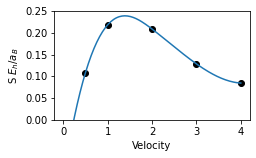

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

x = np.linspace(0, 4, 128)
ax.plot(x, stop_pow_fun(x))
ax.scatter(stopping_powers_100['velocity'],
           stopping_powers_100['stopping'], marker='o', color='k')

ax.set_ylim(0, 0.25)
ax.set_xlabel('Velocity')
ax.set_ylabel('S $E_h/a_B$')

The interpolator looks reasonably smooth

## Make a tool to compute the trajectory
Use the same ODE solver we use for the ML model

In [5]:
def compute_stopping_trajectory(stopping_fun, v_init: float = 4, v_final: float = 0.4, 
                                max_time: float = 1e6, output: int = 10):
    """Compute the trajectory for a projectile moving through a material
    
    Args:
        stopping_fun: Function that predicts the stopping power given velocity
        v_init: Starting velocity
        v_final: Velocity at end of run
        max_time: Maximum allowed run time
        output: Frequency at which to output position and state
    Returns:
        Dataframe containing the projectile history
    """
    
    
    def fun(t, y):
        # Get the velocity and displacement
        v, x = y

        # Compute the force
        f = stop_pow_fun(v)
        return [-f / 1837, v]
    rk = RK45(fun, 0, [v_init, 0], max_time, max_step=0.1)

    # Iterate until velocity slows down enough
    i = 0
    states = [(0, v_init, 0)]
    while rk.y[0] > v_final:
        rk.step()
        i += 1
        if output is not None and i % output == 0:
            states.append(np.hstack(([rk.t], rk.y)))
            
    # Make them into a DataFrame
    traj = pd.DataFrame(states, columns=['time', 'velocity', 'displacement'])
    return traj

In [6]:
%%time
traj = compute_stopping_trajectory(stop_pow_fun)

CPU times: user 41.2 s, sys: 97.7 ms, total: 41.3 s
Wall time: 41.3 s


In [7]:
traj.to_csv('tddft-interpolated-100.csv', index=False)

Text(0, 0.5, 'Velocity (a.u.)')

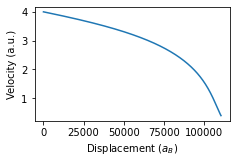

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(traj['displacement'], traj['velocity'])
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')